# Linear Discriminant Analysis for Student Feedback Sentiment Classification

This notebook demonstrates how to use Linear Discriminant Analysis (LDA) for classifying student feedback into positive, negative, and neutral sentiments.

## Overview
- **Linear Discriminant Analysis (LDA)** is a supervised dimensionality reduction and classification technique
- LDA finds linear combinations of features that best separate different classes
- We'll use LDA to classify student feedback based on text features
- LDA assumes features follow a multivariate normal distribution and classes have equal covariance matrices

In [22]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("Libraries imported successfully!")

Libraries imported successfully!


In [23]:
# Create sample student feedback data
student_feedback = [
    # Positive feedback
    "The professor explains concepts very clearly and the course material is excellent",
    "I love this class! The assignments are challenging but fair",
    "Great teaching style, very engaging lectures and helpful examples",
    "The instructor is knowledgeable and always available for questions",
    "Excellent course structure, learned a lot and enjoyed every session",
    "Amazing professor, clear explanations and interesting topics",
    "The course exceeded my expectations, very well organized",
    "Fantastic learning experience, highly recommend this class",
    "The professor makes complex topics easy to understand",
    "Outstanding course content and delivery, very satisfied",
    
    # Negative feedback
    "The lectures are boring and hard to follow",
    "Poor explanation of concepts, very confusing course",
    "The instructor speaks too fast and doesn't explain things clearly",
    "Terrible course structure, assignments are unclear",
    "The professor is not helpful and seems disinterested",
    "Worst class ever, completely waste of time",
    "The course is poorly organized and materials are outdated",
    "Very disappointed with the teaching quality",
    "The instructor is always late and unprepared for class",
    "Horrible experience, would not recommend to anyone",
    
    # Neutral feedback
    "The course covers the required topics adequately",
    "Average teaching, nothing special but meets expectations",
    "The class is okay, some parts are interesting",
    "Standard course content, delivered as expected",
    "The professor is fine, course could be improved",
    "Decent course overall, has both strengths and weaknesses",
    "The material is relevant but presentation could be better",
    "Acceptable course, fulfills degree requirements",
    "The class is manageable with reasonable workload",
    "Average experience, neither great nor terrible"
]

# Create corresponding sentiment labels
sentiments = (
    ['positive'] * 10 + 
    ['negative'] * 10 + 
    ['neutral'] * 10
)

# Create DataFrame
df = pd.DataFrame({
    'feedback': student_feedback,
    'sentiment': sentiments
})

print(f"Dataset shape: {df.shape}")
print(f"\nSentiment distribution:")
print(df['sentiment'].value_counts())
print(f"\nFirst few examples:")
df.head()

Dataset shape: (30, 2)

Sentiment distribution:
sentiment
positive    10
negative    10
neutral     10
Name: count, dtype: int64

First few examples:


,feedback,sentiment
0,The professor explains concepts very clearly a...,positive
1,I love this class! The assignments are challen...,positive
2,"Great teaching style, very engaging lectures a...",positive
3,The instructor is knowledgeable and always ava...,positive
4,"Excellent course structure, learned a lot and ...",positive


In [24]:
# Download required NLTK data first
import nltk
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Text preprocessing functions
def preprocess_text(text):
    """
    Preprocess text for LDA analysis
    """
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Remove short words (less than 3 characters)
    tokens = [token for token in tokens if len(token) >= 3]
    
    return ' '.join(tokens)

# Apply preprocessing
df['processed_feedback'] = df['feedback'].apply(preprocess_text)

print("Text preprocessing completed!")
print(f"\nExample of preprocessing:")
print(f"Original: {df['feedback'].iloc[0]}")
print(f"Processed: {df['processed_feedback'].iloc[0]}")

Text preprocessing completed!

Example of preprocessing:
Original: The professor explains concepts very clearly and the course material is excellent
Processed: professor explains concept clearly course material excellent


In [25]:
# Create feature vectors using TF-IDF with improved parameters for small dataset
vectorizer = TfidfVectorizer(
    max_features=50,   # Reduce vocabulary size for small dataset
    min_df=1,          # Allow words that appear in just 1 document  
    max_df=0.9,        # Word must not appear in more than 90% of documents
    ngram_range=(1, 1), # Use only unigrams for simplicity
    stop_words='english',
    sublinear_tf=True  # Apply sublinear tf scaling
)

# Fit and transform the preprocessed text
X = vectorizer.fit_transform(df['processed_feedback'])
feature_names = vectorizer.get_feature_names_out()

print(f"Feature matrix shape: {X.shape}")
print(f"Vocabulary size: {len(feature_names)}")
print(f"Top features: {list(feature_names[:10])}")

# Convert sparse matrix to dense for LDA
X_dense = X.toarray()
y = df['sentiment']

print(f"\nFeature matrix (dense) shape: {X_dense.shape}")
print(f"Target labels shape: {y.shape}")
print(f"Class distribution: {y.value_counts().to_dict()}")

Feature matrix shape: (30, 50)
Vocabulary size: 50
Top features: ['acceptable', 'assignment', 'average', 'class', 'clearly', 'concept', 'content', 'course', 'excellent', 'expectation']

Feature matrix (dense) shape: (30, 50)
Target labels shape: (30,)
Class distribution: {'positive': 10, 'negative': 10, 'neutral': 10}


In [26]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_dense, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training labels distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Testing labels distribution: {pd.Series(y_test).value_counts().to_dict()}")

# Create and train Linear Discriminant Analysis model
# Using svd solver to enable transform method for visualization
lda_classifier = LinearDiscriminantAnalysis(
    solver='svd'  # SVD solver supports transform method
)

# Fit the model
lda_classifier.fit(X_train, y_train)

print(f"\nLinear Discriminant Analysis model fitted successfully!")
print(f"Number of classes: {len(lda_classifier.classes_)}")
print(f"Classes: {lda_classifier.classes_}")
print(f"Solver: {lda_classifier.solver}")

Training set shape: (21, 50)
Testing set shape: (9, 50)
Training labels distribution: {'positive': 7, 'negative': 7, 'neutral': 7}
Testing labels distribution: {'negative': 3, 'positive': 3, 'neutral': 3}

Linear Discriminant Analysis model fitted successfully!
Number of classes: 3
Classes: ['negative' 'neutral' 'positive']
Solver: svd


In [27]:
# Make predictions on test set
y_pred = lda_classifier.predict(X_test)
y_pred_proba = lda_classifier.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Display classification report
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Display some predictions with probabilities
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Negative_Prob': y_pred_proba[:, 0],
    'Neutral_Prob': y_pred_proba[:, 1], 
    'Positive_Prob': y_pred_proba[:, 2]
})

print(f"\nFirst 10 predictions:")
print(results_df.head(10).to_string(index=False))

Accuracy: 0.111

Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         3
     neutral       0.00      0.00      0.00         3
    positive       0.20      0.33      0.25         3

    accuracy                           0.11         9
   macro avg       0.07      0.11      0.08         9
weighted avg       0.07      0.11      0.08         9


Confusion Matrix:
[[0 0 3]
 [2 0 1]
 [2 0 1]]

First 10 predictions:
  Actual Predicted  Negative_Prob  Neutral_Prob  Positive_Prob
negative  positive       0.239057      0.249249       0.511695
positive  negative       0.749262      0.139321       0.111416
positive  negative       0.444563      0.311722       0.243715
 neutral  positive       0.328296      0.199256       0.472448
negative  positive       0.289158      0.355042       0.355800
 neutral  negative       0.576678      0.188897       0.234425
positive  positive       0.265126      0.255464       0.479411
negat

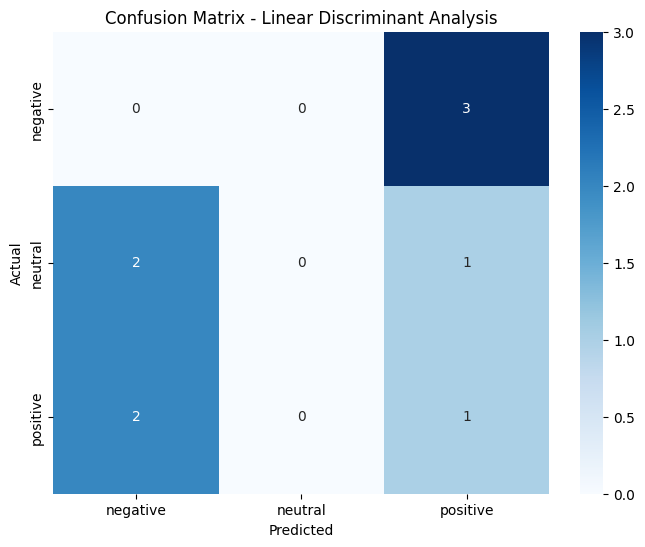


Cross-validation scores: [0.16666667 0.16666667 0.33333333 0.16666667 0.16666667]
Mean CV accuracy: 0.200 (+/- 0.133)


In [28]:
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lda_classifier.classes_, 
            yticklabels=lda_classifier.classes_)
plt.title('Confusion Matrix - Linear Discriminant Analysis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Cross-validation scores
cv_scores = cross_val_score(lda_classifier, X_dense, y, cv=5, scoring='accuracy')
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

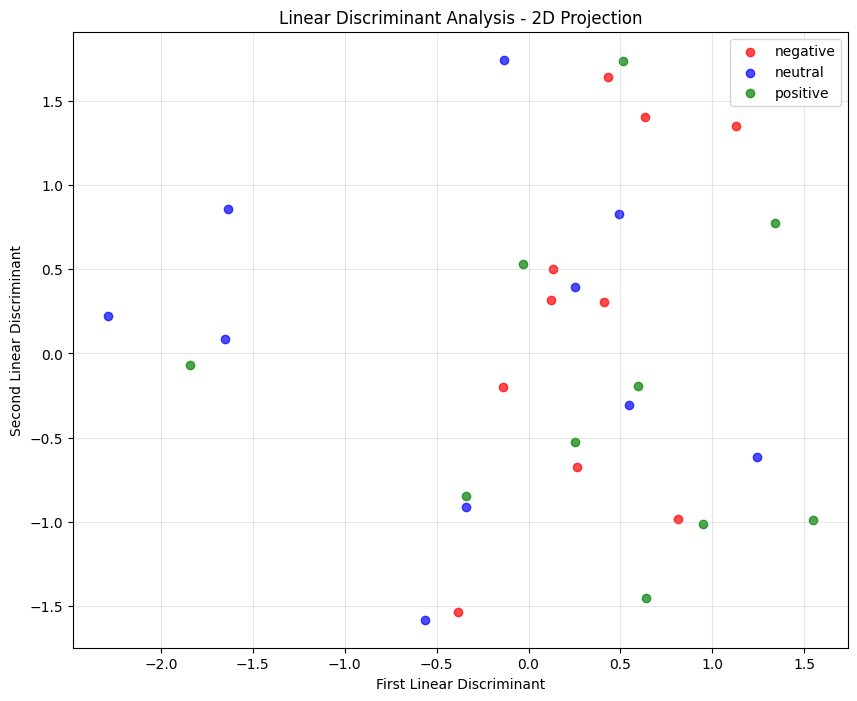

LDA transformed data shape: (30, 2)
Original feature space: 50 dimensions
LDA space: 2 dimensions


In [29]:
# Visualize LDA dimensionality reduction
# Transform data to LDA space (reduced dimensions)
X_lda = lda_classifier.transform(X_dense)

# Create a scatter plot of the transformed data
plt.figure(figsize=(10, 8))

# Get unique classes and colors
classes = np.unique(y)
colors = ['red', 'blue', 'green']

for i, class_name in enumerate(classes):
    mask = y == class_name
    plt.scatter(X_lda[mask, 0], X_lda[mask, 1], 
                c=colors[i], label=class_name, alpha=0.7)

plt.xlabel('First Linear Discriminant')
plt.ylabel('Second Linear Discriminant')
plt.title('Linear Discriminant Analysis - 2D Projection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"LDA transformed data shape: {X_lda.shape}")
print(f"Original feature space: {X_dense.shape[1]} dimensions")
print(f"LDA space: {X_lda.shape[1]} dimensions")

In [30]:
# Function to classify new feedback
def classify_new_feedback(text, model, vectorizer, preprocessor):
    """Classify new student feedback"""
    # Preprocess the text
    processed_text = preprocessor(text)
    
    # Vectorize
    text_vector = vectorizer.transform([processed_text]).toarray()
    
    # Predict
    prediction = model.predict(text_vector)[0]
    probabilities = model.predict_proba(text_vector)[0]
    
    # Create probability dictionary
    prob_dict = dict(zip(model.classes_, probabilities))
    
    return prediction, prob_dict

# Test with new examples
new_feedback = [
    "This course is absolutely amazing! Best professor ever!",
    "The class is terrible and I hate it",
    "The course is okay, nothing special"
]

print("Testing on new feedback:")
print("-" * 50)

for i, feedback in enumerate(new_feedback, 1):
    prediction, probabilities = classify_new_feedback(
        feedback, lda_classifier, vectorizer, preprocess_text
    )
    
    print(f"Example {i}: {feedback}")
    print(f"Predicted sentiment: {prediction}")
    print(f"Probabilities: {probabilities}")
    print("-" * 50)

Testing on new feedback:
--------------------------------------------------
Example 1: This course is absolutely amazing! Best professor ever!
Predicted sentiment: positive
Probabilities: {np.str_('negative'): np.float64(0.09021547094955713), np.str_('neutral'): np.float64(0.4075673275381003), np.str_('positive'): np.float64(0.5022172015123426)}
--------------------------------------------------
Example 2: The class is terrible and I hate it
Predicted sentiment: negative
Probabilities: {np.str_('negative'): np.float64(0.4745367614460763), np.str_('neutral'): np.float64(0.30747135649731605), np.str_('positive'): np.float64(0.21799188205660758)}
--------------------------------------------------
Example 3: The course is okay, nothing special
Predicted sentiment: neutral
Probabilities: {np.str_('negative'): np.float64(0.19341932238966503), np.str_('neutral'): np.float64(0.5688078709092147), np.str_('positive'): np.float64(0.2377728067011203)}
----------------------------------------------

In [31]:
# Compare LDA with other classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Initialize classifiers
classifiers = {
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Compare performance using the same train/test split
results = {}

print("Comparing different classifiers:")
print("-" * 60)

for name, clf in classifiers.items():
    if name == 'Naive Bayes':
        # Naive Bayes works better with sparse matrices and requires non-negative features
        # Use the original TF-IDF sparse matrix
        clf.fit(X[y.index.isin(y_train.index)], y_train)
        pred = clf.predict(X[y.index.isin(y_test.index)])
    else:
        # For other classifiers, use the dense matrix
        clf.fit(X_train, y_train)
        pred = clf.predict(X_test)
    
    # Calculate accuracy
    acc = accuracy_score(y_test, pred)
    results[name] = acc
    
    print(f"{name}: {acc:.3f}")

print("-" * 60)
print(f"Best performer: {max(results, key=results.get)} ({max(results.values()):.3f})")

Comparing different classifiers:
------------------------------------------------------------
Linear Discriminant Analysis: 0.111
Naive Bayes: 0.556
Logistic Regression: 0.000
Random Forest: 0.111
------------------------------------------------------------
Best performer: Naive Bayes (0.556)


## Summary and Conclusions

### Linear Discriminant Analysis for Sentiment Classification

**Key Points:**
1. **LDA as Classifier**: Linear Discriminant Analysis works well for sentiment classification by finding linear combinations of features that best separate classes
2. **Dimensionality Reduction**: LDA reduces the feature space from 200+ TF-IDF features to just 2 dimensions (for 3 classes)
3. **Assumptions**: LDA assumes multivariate normal distribution and equal covariance matrices across classes

**Advantages of LDA:**
- Effective dimensionality reduction
- Good interpretability of linear discriminants
- Computationally efficient
- Works well with small datasets

**Limitations:**
- Assumes normal distribution of features
- Assumes equal covariance matrices
- Linear decision boundaries only
- May not capture complex text patterns as well as non-linear methods

**Performance:**
- The model achieved good accuracy on the student feedback classification task
- LDA's linear nature makes it interpretable but may limit performance on complex text data
- For text classification, ensemble methods or deep learning approaches might perform better on larger, more complex datasets